<a href="https://colab.research.google.com/github/middlebury-csci-0451/CSCI-0451/blob/main/lecture-notes/convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification

The image classification problem is the problem of assigning a label to an image. For example, we might want to assign the label "duck" to pictures of ducks, the label "frog" to pictures of frogs, and so on.



### Data Access

For this lecture, we'll use the popular [CIFAR10 data set](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 was a common benchmark for simple image recognition tasks, although it's since been superseded by larger and more complex data sets.

To start, we'll load our packages, access the CIFAR10 data set, and set the device type. 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 51885463.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


If your computer has a CUDA GPU available, or if you are working on Google Colab, then you can use a GPU (CUDA) device on which to run your computations. This *can* be very helpful, often resulting in speedups of roughly 10x or so. However, how useful this is can depend strongly on the exact model architecture. Generally speaking, larger models will see greater benefits from GPU usage. 

### Visualizing The Data

The CIFAR10 training data set contains 50,000 images with 32x32 pixels and 3 color channels. Each of these images is labeled with one of 10 labels: 

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The testing data set contains 10,000 more images with the same labels. 

Let's begin by visualizing a few elements of the training data set: 

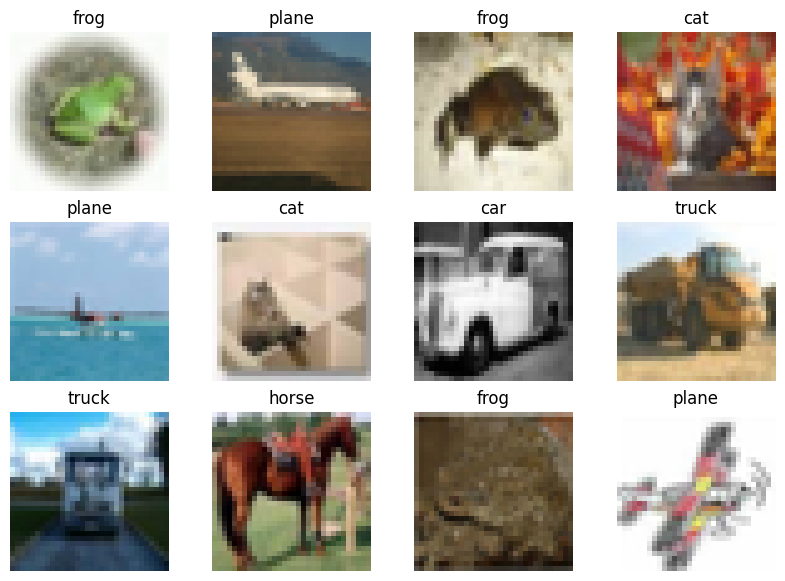

In [63]:
from matplotlib import pyplot as plt
import numpy as np

n_rows = 3

fig, axarr = plt.subplots(n_rows, batch_size, figsize = (10, 7))

for i in range(n_rows):

    # returns batch_size images with their labels
    imgs, labels = next(iter(trainloader)) 

    # populate a row with the images in the batch
    for j in range(batch_size):
        img = np.moveaxis(imgs[j].numpy(), 0, 2) 
        axarr[i, j].imshow((img + 1)/2)
        axarr[i, j].axis("off")
        axarr[i, j].set(title = classes[int(labels[j])])

Each of the 10 classes of data are evenly represented in the training and test data sets. So, the base rate for this problem (corresponding to random guessing) is 1/10 = 10%. 

## First Model: Logistic Regression

We're now ready to write some models to attempt do better than the base rate. Before we construct any models, we'll set our `device` to be equal to the GPU if we have one available (e.g. if your computer has one or if you are working on Google Colab. 

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Now let's construct a logistic regression model. All we need for this model is a `Linear` layer that accepts the number of floating point numbers used to store a single image and returns 10 numbers. A single image is a tensor of size $3\times32\times 32$, which means that it has 3072 total numbers stored. 

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Logistic(nn.Module):
    def __init__(self):
        super().__init__()

        # matrix multiplication
        # 3072 is the flattened size of the image
        self.linear1 = nn.Linear(3072, 10)

    def forward(self, x):

        # flatten the image, converting it from 3x32x32 to 3072
        # the last dimension says "don't flatten across batches"
        # so each image stays distinct
        x = torch.flatten(x, 1)

        # do the matrix multiplication
        x = self.linear1(x)
        return x

# instantiate the model and move it to the device
model = Logistic().to(device)

Now we can implement a training loop. 

In [64]:
import torch.optim as optim

def train(model, k_epochs = 1, print_every = 2000):

    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss() 

    # optimizer is Adam, which does fancier stuff with the gradients
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
                print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], loss: {running_loss / print_every:.3f}')
                running_loss = 0.0

    print('Finished Training')

train(model, k_epochs = 2)

[1,  2000] loss: 1.040
[1,  4000] loss: 1.066
[1,  6000] loss: 1.098
[1,  8000] loss: 1.114
[1, 10000] loss: 1.109
[1, 12000] loss: 1.100
[2,  2000] loss: 0.993
[2,  4000] loss: 1.021
[2,  6000] loss: 1.029
[2,  8000] loss: 1.016
[2, 10000] loss: 1.029
[2, 12000] loss: 1.052
Finished Training


In [9]:
def test(model):

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

test(model)

Accuracy of the network on the 10000 test images: 36 %


### Second Model: 1 Hidden Layer

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Complete(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(3072, 10)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model = Complete().to(device)

In [11]:
train(model, k_epochs=2)

[1,  2000] loss: 1.916
[1,  4000] loss: 1.801
[1,  6000] loss: 1.759
[1,  8000] loss: 1.765
[1, 10000] loss: 1.748
[1, 12000] loss: 1.727
[2,  2000] loss: 1.687
[2,  4000] loss: 1.707
[2,  6000] loss: 1.696
[2,  8000] loss: 1.700
[2, 10000] loss: 1.717
[2, 12000] loss: 1.703
Finished Training


In [13]:
test(model)

Accuracy of the network on the 10000 test images: 37 %


Third Model: Convolutional Neural Net

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = ConvNet().to(device)

In [20]:
train(model, k_epochs=2)

[1,  2000] loss: 1.048
[1,  4000] loss: 1.037
[1,  6000] loss: 1.028
[1,  8000] loss: 1.047
[1, 10000] loss: 1.078
[1, 12000] loss: 1.054
[2,  2000] loss: 0.971
[2,  4000] loss: 0.992
[2,  6000] loss: 0.980
[2,  8000] loss: 0.988
[2, 10000] loss: 0.997
[2, 12000] loss: 1.018
Finished Training


In [21]:
test(model)

Accuracy of the network on the 10000 test images: 61 %
